In [ ]:
#Proyecto: Clasificación de galaxias mediante imágenes (clasificación multietiqueta)
#Objetivo: Desarrollar un modelo de aprendizaje automático capaz de clasificar galaxias en múltiples categorías basándose en imágenes astronómicas.

#Importar paquetes necesarios
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchmetrics import PearsonCorrCoef
from sklearn.metrics import confusion_matrix

#Configuraciones generales
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_EPOCHS = 25
LEARNING_RATE = 1e-3
DATA_DIR = '.\Datasets'

#Fijar la semilla par reproductividad
SEED = 42  # puedes elegir cualquier número


torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f'DEVICE: {DEVICE}')
IMG_TRAIN_DIR = os.path.join(DATA_DIR, 'images_training_rev1')
IMG_TEST_DIR = os.path.join(DATA_DIR, 'images_test_rev1')
LABELS_CSV = os.path.join(DATA_DIR, 'training_solutions_rev1.csv')
SUBMISSION_CSV = os.path.join(DATA_DIR, 'all_zeros_benchmark.csv')

DEVICE: cuda


In [2]:
#Preprocesamientos

labels_df = pd.read_csv(LABELS_CSV) #Lectura del archivo CSV de etiquetas
print(f'Labels DataFrame shape: {labels_df.shape}')
print(f'First 8 columns: {labels_df.columns[:8].to_list()}')

bench = pd.read_csv(SUBMISSION_CSV) #Lectura del archivo CSV de benchmark
#Usar el orden de las filas del benchmark para el conjunto de prueba y estar seguros de que las predicciones se alinean correctamente
target_cols = bench.columns[1:].to_list()
print(f'Benchmark DataFrame shape: {bench.shape}')
print(f'Target columns: {target_cols}')

#Asegurarse de que las columnas de etiquetas coincidan con las del benchmark y estén en el mismo orden
missing_taget_cols = [col for col in target_cols if col not in labels_df.columns]
assert len(missing_taget_cols) == 0, f'Missing target columns in labels_df: {missing_taget_cols}'


Labels DataFrame shape: (61578, 38)
First 8 columns: ['GalaxyID', 'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1', 'Class3.2']
Benchmark DataFrame shape: (79975, 38)
Target columns: ['Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2', 'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2', 'Class7.3', 'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6', 'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1', 'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3', 'Class11.4', 'Class11.5', 'Class11.6']


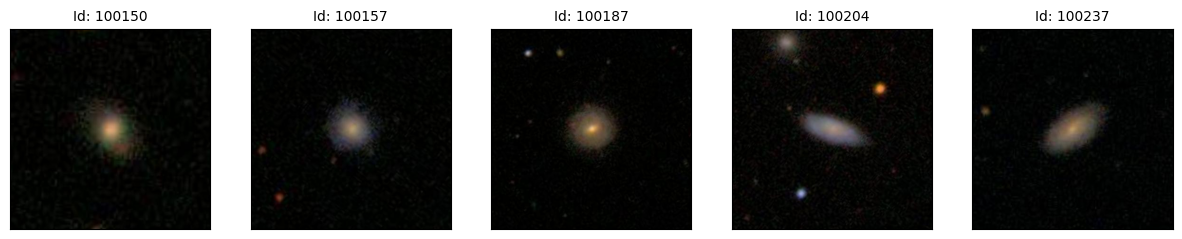

In [3]:
#Visualización de imágenes

def show_image(dir, num_images=5, ids=None):
    fig = plt.figure(figsize=(15, 5))
    for j in range(10, 10 + num_images):
        img_path = os.path.join(dir, str(ids[j]) + '.jpg')
        img = imread(img_path) 
        ax = fig.add_subplot(1, num_images, j - 10 + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
        ax.set_title(f'Id: {ids[j]}', fontsize=10)  
    plt.show()

labels_id = labels_df['GalaxyID'].tolist()
show_image(IMG_TRAIN_DIR, num_images=5, ids=labels_id)

In [4]:
#Definir los transformadores de datos

#Redimensionar todas las imágenes a un tamaño fijo (ahora mismo son de 424x424)
SIZE = 224

transform_train = transforms.Compose([
    transforms.Resize([SIZE, SIZE]),
    transforms.RandomCrop(SIZE, padding=4), #recorte aleatorio con relleno (a veces con relleno a veces no)
    transforms.RandomHorizontalFlip(), #volteo horizontal aleatorio
    transforms.RandomRotation(15),  #rotación aleatoria 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize([SIZE, SIZE]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


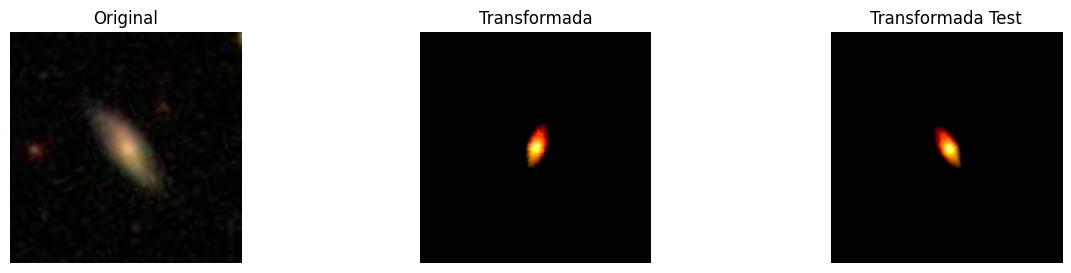

Original image shape: (424, 424)
Transformed image shape (train): (224, 224, 3)
Transformed image shape (test): (224, 224, 3)


In [5]:
#Comprobar los transformadores de datos en imágenes y mostrar una imagen transformada

img_id = labels_id[1]
img_path = os.path.join(IMG_TRAIN_DIR, str(img_id) + '.jpg')
img = Image.open(img_path)

fig = plt.figure(figsize=(15, 3))

# Original
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img)
ax.set_title("Original")
ax.axis("off")

# Transformada con train transform
img_transformed = transform_train(img)   
img_transformed = img_transformed.permute(1, 2, 0).numpy()

ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_transformed)
ax.set_title("Transformada")
ax.axis("off")

#Transformada con test transform
img_transformed_test = transform_test(img)  
img_transformed_test = img_transformed_test.permute(1, 2, 0).numpy()

ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_transformed_test)
ax.set_title("Transformada Test")
ax.axis("off")

plt.show()

print(f'Original image shape: {img.size}')
print(f'Transformed image shape (train): {img_transformed.shape}')
print(f'Transformed image shape (test): {img_transformed_test.shape}')

In [6]:
#Crear el dataset personalizado y cargar en el DataLoader

#Dado que no se dispone de las etiquetas del test nos enfocaremos en el dataset de entrenamiento y validación
class GalaxyDataset(Dataset):
    def __init__(self, images_dir, labels_id,  labels, transform=None):
        self.images_dir = images_dir
        self.labels_id = labels_id
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.labels[self.labels.columns[0]])
    
    def __getitem__(self, idx):
        img_id = self.labels_id[idx]
        img_path = os.path.join(self.images_dir, str(img_id) + '.jpg')
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels.iloc[idx].values, dtype=torch.float32)

        return image, label

labels_id = labels_df['GalaxyID'].tolist()
target_cols = bench.columns[1:].to_list()

max_train_size = len(labels_df) - (len(labels_df) // 5) #80% para entrenamiento, 20% para validación
galaxy_train_labels_id = Subset(labels_id, list(range(0, max_train_size))) #muestras para entrenamiento
galaxy_val_labels_id = Subset(labels_id, list(range(max_train_size, len(labels_df)))) #resto para validación

train_labels_raw_scaled = (labels_df.iloc[galaxy_train_labels_id.indices][target_cols])
val_labels_raw_scaled = (labels_df.iloc[galaxy_val_labels_id.indices][target_cols])

galaxy_train_dataset = GalaxyDataset(IMG_TRAIN_DIR, galaxy_train_labels_id, train_labels_raw_scaled, transform=transform_train)
galaxy_val_dataset = GalaxyDataset(IMG_TRAIN_DIR, galaxy_val_labels_id, val_labels_raw_scaled, transform=transform_test)

num_cores = os.cpu_count()
#Crear los DataLoaders
galaxy_train_dl = DataLoader(galaxy_train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
galaxy_val_dl = DataLoader(galaxy_val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

print('Num cores / 2: ', num_cores//2)
print(f'Number of training samples: {len(galaxy_train_dataset)}')
print(f'Number of validation samples: {len(galaxy_val_dataset)}')



Num cores / 2:  8
Number of training samples: 49263
Number of validation samples: 12315


In [ ]:
#Creacion de un modelo de red neuronal convolucional (CNN) usando la GPU

class GalaxyCNN(nn.Module):
    def __init__(self, num_classes=len(target_cols)):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) #3 canales de entrada (RGB), 32 filtros (detectar patrones locales borde)
        self.pool1 = nn.MaxPool2d(2, 2) #Reducción de dimensionalidad y extracción de características

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.AvgPool2d(2, 2)

        alto_ancho_final = SIZE // 16  #Reducción de tamaño tras 4 capas de pooling
        self.Flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * alto_ancho_final * alto_ancho_final, 512) # fc1: salida adaptada a 256 canales  
        self.out = nn.Linear(512, num_classes)
        self.relu = nn.ReLU() #ReLU: introduce no linealidad, permite aprender patrones complejos
        self.dropout = nn.Dropout(0.3) #Dropout: técnica de regularización para prevenir sobreajuste

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        x = self.relu(self.conv2(x))
        x = self.pool2(x)

        x = self.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.relu(self.conv4(x))
        x = self.pool4(x)

        x = self.Flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.out(x)
        return x

model = GalaxyCNN().to(DEVICE)
print(model)

GalaxyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=37, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


In [8]:
import time
start = time.time()
x_batch, y_batch = next(iter(galaxy_train_dl))
end = time.time()
print(f'Tiempo para cargar un batch: {end-start:.2f}s')

#Conprobar la salida del modelo y dimensiones
x_batch = x_batch.to(DEVICE)
y_batch = y_batch.to(DEVICE)
start = time.time()
outputs = model(x_batch)
end = time.time()
print(f'Tiempo para pasar un batch por el modelo: {end-start:.2f}s')
print(f'Input batch shape: {x_batch.shape}')
print(f'Output batch shape: {outputs.shape}')


Tiempo para cargar un batch: 0.20s
Tiempo para pasar un batch por el modelo: 0.62s
Input batch shape: torch.Size([32, 3, 224, 224])
Output batch shape: torch.Size([32, 37])


In [9]:
# Función de pérdida: BCEWithLogitsLoss para clasificación multietiqueta
loss_fn = nn.BCEWithLogitsLoss()

# Optimizador: Adam con tasa de aprendizaje de 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [10]:
def train_val_model(num_epochs, model, dl_train, dl_val, loss_fn, optimizer, device=DEVICE):
    train_loss, val_loss = [], []
    train_corr_list, val_corr_list = [], []

    #Definir métricas
    train_corr_metric = PearsonCorrCoef(num_outputs=37).to(device) #Calcualr los valores de esta forma mejor que a mano, más preciso
    val_corr_metric = PearsonCorrCoef(num_outputs=37).to(device)

    for epoch in range(num_epochs):
    
        model.train()
        loss_hist = 0
        train_corr_metric.reset()
        
        for x_batch, y_batch in dl_train:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()

            loss_hist += loss.item() * y_batch.size(0)

            #Actualizar métrica
            train_corr_metric.update(torch.sigmoid(pred), y_batch)

        epoch_loss = loss_hist / len(dl_train.dataset)
        epoch_corr = train_corr_metric.compute().mean().item()  # promedio sobre todas las clases
        train_loss.append(epoch_loss)
        train_corr_list.append(epoch_corr)


        model.eval()
        loss_hist = 0
        val_corr_metric.reset()
        with torch.no_grad():
            for x_batch, y_batch in dl_val:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist += loss.item() * y_batch.size(0)
                val_corr_metric.update(torch.sigmoid(pred), y_batch)

        epoch_loss_val = loss_hist / len(dl_val.dataset)
        epoch_corr_val = val_corr_metric.compute().mean().item()
        val_loss.append(epoch_loss_val)
        val_corr_list.append(epoch_corr_val)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train CORR: {epoch_corr:.4f}, '
              f'Val Loss: {epoch_loss_val:.4f}, Val CORR: {epoch_corr_val:.4f}')

    return train_loss, train_corr_list, val_loss, val_corr_list

#Entrenamiento
tr_loss, tr_corr, val_loss, val_corr = train_val_model(NUM_EPOCHS, model, galaxy_train_dl, galaxy_val_dl, loss_fn, optimizer, DEVICE)


Epoch 1/25, Train Loss: 0.2750, Train CORR: 0.3742, Val Loss: 0.2553, Val CORR: 0.5573
Epoch 2/25, Train Loss: 0.2535, Train CORR: 0.5616, Val Loss: 0.2458, Val CORR: 0.6253
Epoch 3/25, Train Loss: 0.2477, Train CORR: 0.6083, Val Loss: 0.2430, Val CORR: 0.6543
Epoch 4/25, Train Loss: 0.2450, Train CORR: 0.6334, Val Loss: 0.2411, Val CORR: 0.6706
Epoch 5/25, Train Loss: 0.2435, Train CORR: 0.6480, Val Loss: 0.2400, Val CORR: 0.6765
Epoch 6/25, Train Loss: 0.2421, Train CORR: 0.6595, Val Loss: 0.2418, Val CORR: 0.6785
Epoch 7/25, Train Loss: 0.2415, Train CORR: 0.6659, Val Loss: 0.2385, Val CORR: 0.6903
Epoch 8/25, Train Loss: 0.2407, Train CORR: 0.6738, Val Loss: 0.2382, Val CORR: 0.6939
Epoch 9/25, Train Loss: 0.2401, Train CORR: 0.6791, Val Loss: 0.2376, Val CORR: 0.7024
Epoch 10/25, Train Loss: 0.2395, Train CORR: 0.6860, Val Loss: 0.2377, Val CORR: 0.7043
Epoch 11/25, Train Loss: 0.2391, Train CORR: 0.6911, Val Loss: 0.2386, Val CORR: 0.6997
Epoch 12/25, Train Loss: 0.2386, Train CO

c:\Users\diego\miniconda3\envs\astro_env\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32). Setting the correlation coefficient to nan.
  warnings.warn(*args, **kwargs)


Epoch 15/25, Train Loss: 0.2375, Train CORR: nan, Val Loss: 0.2358, Val CORR: 0.7195
Epoch 16/25, Train Loss: 0.2372, Train CORR: 0.7101, Val Loss: 0.2372, Val CORR: 0.7106
Epoch 17/25, Train Loss: 0.2369, Train CORR: 0.7134, Val Loss: 0.2356, Val CORR: 0.7205
Epoch 18/25, Train Loss: 0.2367, Train CORR: 0.7161, Val Loss: 0.2355, Val CORR: 0.7210
Epoch 19/25, Train Loss: 0.2365, Train CORR: 0.7168, Val Loss: 0.2365, Val CORR: 0.7171
Epoch 20/25, Train Loss: 0.2363, Train CORR: 0.7193, Val Loss: 0.2355, Val CORR: 0.7199
Epoch 21/25, Train Loss: 0.2361, Train CORR: 0.7198, Val Loss: 0.2359, Val CORR: 0.7172
Epoch 22/25, Train Loss: 0.2359, Train CORR: 0.7219, Val Loss: 0.2355, Val CORR: 0.7209
Epoch 23/25, Train Loss: 0.2357, Train CORR: 0.7238, Val Loss: 0.2351, Val CORR: 0.7224
Epoch 24/25, Train Loss: 0.2355, Train CORR: 0.7264, Val Loss: 0.2359, Val CORR: nan
Epoch 25/25, Train Loss: 0.2353, Train CORR: nan, Val Loss: 0.2357, Val CORR: 0.7225


NameError: name 'tr_loss' is not defined

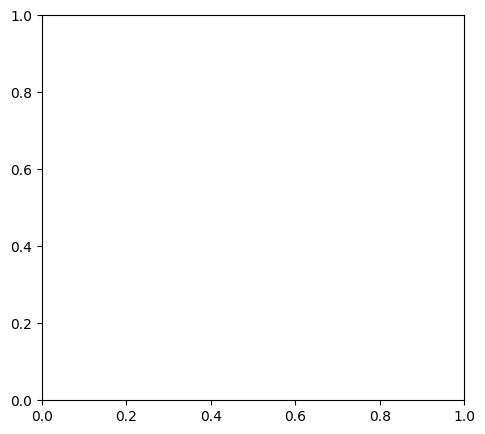

In [10]:
#Graficar las curvas de pérdida y precisión
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(tr_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Val Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tr_corr, label='Train Acc', color='blue')
plt.plot(val_corr, label='Val Acc', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
#Guardar el modelo
torch.save(model.state_dict(), "./results/galaxycnn_weights.pth")

GalaxyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=37, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

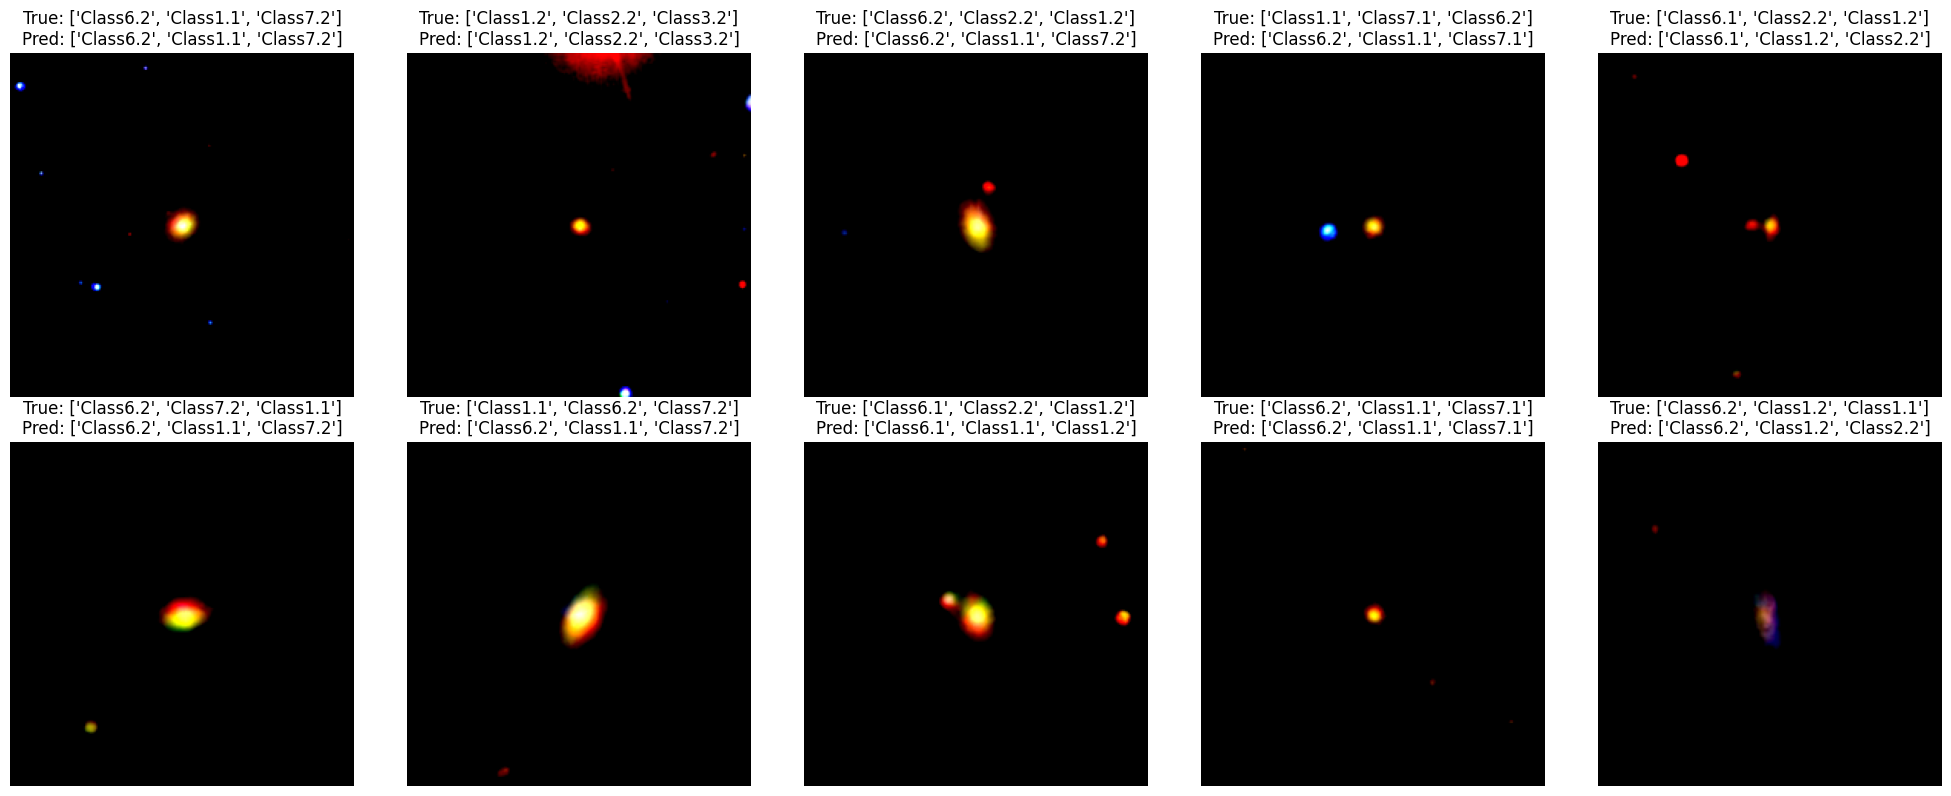

In [10]:
#Mostrar predicciones
#Dado que una galaxia puede pertenecer a varias clases se va a obtener el mayor índice de la verdadera y comparar con la predicción

#Cargar el modelo
model_2 = GalaxyCNN(num_classes=len(target_cols))  
model_2.load_state_dict(torch.load("./results/galaxycnn_weights.pth"))

model_2.to(DEVICE)

def show_pred_top3(dataloader, model, device, num_examples=10):
    model.eval()
    images_shown = 0
    images_per_row = 5

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)
            pred_probs = torch.sigmoid(pred)  #Convertir logits a probabilidades

            batch_size = x_batch.size(0)
            for i in range(batch_size):
                if images_shown == 0:
                    rows = int(np.ceil(num_examples / images_per_row))
                    fig, axes = plt.subplots(rows, images_per_row, figsize=(4*images_per_row, 4*rows))
                    axes = axes.flatten()
                
                img = x_batch[i].cpu().numpy()          
                img = np.transpose(img, (1,2,0))       
                axes[images_shown].imshow(img)
                axes[images_shown].axis("off")
                
                # Obtener top 3 predichas
                top3_pred_idx = torch.topk(pred_probs[i], k=3).indices.cpu().numpy()
                top3_pred = [target_cols[j] for j in top3_pred_idx]

                # Obtener top 3 verdaderas
                top3_true_idx = torch.topk(y_batch[i], k=3).indices.cpu().numpy()
                top3_true = [target_cols[j] for j in top3_true_idx]

                axes[images_shown].set_title(f"True: {top3_true}\nPred: {top3_pred}")

                images_shown += 1
                if images_shown >= num_examples:
                    plt.tight_layout()
                    plt.show()
                    return pred_probs  


pred = show_pred_top3(galaxy_val_dl, model_2, DEVICE)


In [ ]:
#Realización de otras comporbaciones
#Analizar que galaxias han sido clasificadas como elipticas (Clase 1.1) o espirales(Clase 1.2) de las etiquetas de soluciones y compararlas con el modelo

#Condiciones para clasificar
conditions = [
    (labels_df['Class1.1'] >= 0.8),
    (labels_df['Class1.2'] >= 0.8)
]

#Clases asociadas a cada condición
choices = ["elliptical", "spiral"]

#Nueva columna con la clase asignada (si cumple varias, toma la primera condición)
labels_df["GalaxyClass"] = np.select(conditions, choices, default="other")

#Filtrar solo las galaxias que cumplen alguna de las condiciones
conditions_labels_df = labels_df[labels_df["GalaxyClass"] != "other"]

#Comparar estas salidas con las del modelo

dummy_labels = pd.DataFrame(np.zeros((len(conditions_labels_df), len(target_cols))), columns=target_cols)
test_ids = conditions_labels_df['GalaxyID'].tolist()

galaxy_test_dataset = GalaxyDataset(IMG_TRAIN_DIR, test_ids, dummy_labels, transform=transform_test)
galaxy_test_dl = DataLoader(galaxy_test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

#Generar predicciones para el conjunto de prueba
model_2.eval()
all_preds = []
with torch.no_grad():
    for x_batch, _ in galaxy_test_dl:
        x_batch = x_batch.to(DEVICE)
        pred = model_2(x_batch)
        #Convertir los logits a probabilidades usando la función sigmoide
        pred_probs = torch.sigmoid(pred)
        all_preds.append(pred_probs.cpu().numpy())

#Concatenar todas las predicciones de los batches
predictions = np.concatenate(all_preds, axis=0)

#Crear el archivo de envío
submission_df = pd.DataFrame(predictions, columns=target_cols)
submission_df.insert(0, 'GalaxyID', test_ids)




In [ ]:
#Comparacion de dataframes

#1. Aplicar condiciones al submision_df
conditions_submission = [
    (submission_df['Class1.1'] >= 0.75), #Aunque deberia de ser 0.8 se aplica un 0.75 para ser un poco mas flexibles ya que hay numerosos datos cerca del 0.8 y que no entraría en ninguna de las condiciones
    (submission_df['Class1.2'] >= 0.75)
]
submission_df["GalaxyClass"] = np.select(conditions_submission, choices, default="other")

#2. Megear los dos datafames y visualizar solo su ultima columna
merged_df = conditions_labels_df.merge(submission_df, on="GalaxyID")

result = merged_df[["GalaxyID", "GalaxyClass_x", "GalaxyClass_y"]]

#3. Mostrar datos y errores

print("------Galaxy df examples------")
print(result.head())
print()
errors = result[result["GalaxyClass_x"] != result["GalaxyClass_y"]]
print("-------GalaxyID errors-------")
print(errors.head())
print()
print("Final count\n",(result["GalaxyClass_x"] == result["GalaxyClass_y"]).value_counts())


------Galaxy df exaples------
   GalaxyID GalaxyClass_x GalaxyClass_y
0    100090    elliptical         other
1    100134        spiral        spiral
2    100237        spiral        spiral
3    100263        spiral         other
4    100322        spiral        spiral

-------GalaxyID errors-------
    GalaxyID GalaxyClass_x GalaxyClass_y
0     100090    elliptical         other
3     100263        spiral         other
5     100335        spiral         other
10    100672    elliptical         other
13    100727    elliptical         other

Final count
 True     18577
False     5696
Name: count, dtype: int64


In [ ]:
#Crear un dataset para las imágenes de prueba, con el obgetivo de generar el csv final que pide el torneo de Galaxy Zoo

#Se crea un DataFrame de etiquetas dummy ya que el dataset las requiere, pero no se usarán
dummy_labels = pd.DataFrame(np.zeros((len(bench), len(target_cols))), columns=target_cols)
test_ids = bench['GalaxyID'].tolist()

galaxy_test_dataset = GalaxyDataset(IMG_TEST_DIR, test_ids, dummy_labels, transform=transform_test)
galaxy_test_dl = DataLoader(galaxy_test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

#Generar predicciones para el conjunto de prueba
model_2.eval()
all_preds = []
with torch.no_grad():
    for x_batch, _ in galaxy_test_dl:
        x_batch = x_batch.to(DEVICE)
        pred = model_2(x_batch)
        #Convertir los logits a probabilidades usando la función sigmoide
        pred_probs = torch.sigmoid(pred)
        all_preds.append(pred_probs.cpu().numpy())

#Concatenar todas las predicciones de los batches
predictions = np.concatenate(all_preds, axis=0)

#Crear el archivo de envío
submission_df = pd.DataFrame(predictions, columns=target_cols)
submission_df.insert(0, 'GalaxyID', test_ids)

#Guardar el archivo de envío
submission_df.to_csv('./results/submission.csv', index=False)

print("Archivo de envío 'submission.csv' creado con éxito.")
print(submission_df.head())

Archivo de envío 'submission.csv' creado con éxito.
   GalaxyID  Class1.1  Class1.2  Class1.3  Class2.1  Class2.2  Class3.1  \
0    100018  0.440796  0.549694  0.016271  0.064338  0.488341  0.060332   
1    100037  0.486638  0.494490  0.011892  0.354834  0.112344  0.013554   
2    100042  0.639766  0.327809  0.014826  0.233374  0.109827  0.018037   
3    100052  0.566581  0.413152  0.021932  0.009689  0.395785  0.015955   
4    100056  0.236389  0.761120  0.006619  0.673303  0.052695  0.014193   

   Class3.2  Class4.1  Class4.2  ...  Class9.3  Class10.1  Class10.2  \
0  0.416074  0.142338  0.348255  ...  0.008927   0.064870   0.049636   
1  0.095789  0.020786  0.108160  ...  0.214762   0.010742   0.006369   
2  0.081150  0.018368  0.100071  ...  0.092982   0.005988   0.005157   
3  0.377213  0.058471  0.310010  ...  0.000787   0.026091   0.018618   
4  0.038796  0.013670  0.044166  ...  0.459881   0.005487   0.004993   

   Class10.3  Class11.1  Class11.2  Class11.3  Class11.4  Class1